# Simulation-based Inference

In [1]:
import torch
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from scipy.stats import moment
from scipy.integrate import solve_ivp

from sbi.simulators import linear_gaussian
from sbi.utils.torchutils import BoxUniform
from sbi.inference import SNPE_C
from sbi.inference import infer
from sbi.analysis import pairplot

from torch import Tensor
from typing import Tuple
from numpy import ndarray

In [2]:
# helper functions for plotting
def beautify_pairplot(axes):
    """Helper function to make pairplots more presentable."""
    for axe in axes:
        for ax in axe:
            plt.setp(ax.spines.values(), linewidth=2.5)
            plt.setp(ax._get_lines(), linewidth=20.5)
            plt.setp(ax.xaxis.get_majorticklabels(), ha="right", wrap=True)
            ax.tick_params(axis="x", width=2.5, labelsize=13, length=6)
            ax.xaxis.label.set_size(15)
    plt.tight_layout()

pairplot_kwargs = {"upper":"kde", "diag":"kde", "points_offdiag":{"markersize": 8, "mew": 2.5, "marker": "x", "lw": 1.5}, "figsize":(6,6), "points_colors":["red"]}

## Observation

### Toy Scenario

We have made an observation $\boldsymbol{x}_o = (1,1)$, that has been generated by some known process, for which a simulator $(x_1,x_2) \sim \mathcal{f}(\theta_1,\theta_2)$ or a way to generate data exists.

In [3]:
# experiment parameters
num_dims = 2

x_o = torch.ones((1,num_dims))

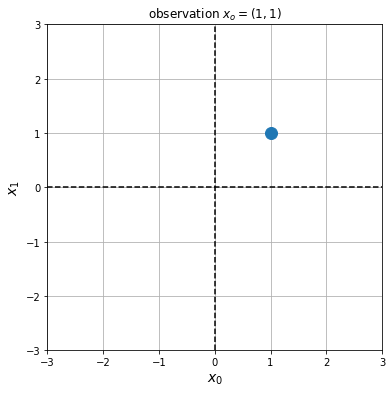

In [4]:
plt.figure(figsize=(6,6))
plt.plot(1,1, "o",ms=12)
plt.axhline(0, c="k", linestyle="--")
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"$x_0$", size=14)
plt.ylabel(r"$x_1$", size=14)
plt.title(r"observation $x_o = (1,1)$")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid(True)
plt.show()

## Simulator

![simulator](figures/simulator.png)

In [5]:
# toy simulator
X = torch.rand(num_dims,num_dims)**2
m = 2*torch.ones((num_dims,))
cov = X.T@X

simulator = partial(linear_gaussian, likelihood_shift=m, likelihood_cov=cov)

In [6]:
theta = torch.rand((1,num_dims))
x = simulator(theta)

print(f"θ = {theta.tolist()} -> simulator -> x = {x.tolist()}")

θ = [[0.7174808979034424, 0.3962346911430359]] -> simulator -> x = [[2.775620698928833, 2.4740757942199707]]


## Density Estimation

![training](figures/density_estimation.png)

In [7]:
# forwards
lower_bound = -3*torch.ones((num_dims,))
upper_bound = 3*torch.ones((num_dims,))
prior = BoxUniform(low=lower_bound, high=upper_bound)

num_samples = 1000
theta = prior.sample((num_samples, ))

x = simulator(theta)

In [8]:
# training
inference = SNPE_C(prior=prior, density_estimator="mdn")
estimator = inference.append_simulations(theta=theta, x=x).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 75 epochs.

## Inference

![inference](figures/inference.png)

In [9]:
posterior.set_default_x(x_o)

num_samples = 10000
samples = posterior.sample((num_samples,))

Drawing 10000 posterior samples: 10098it [00:00, 2733050.38it/s]          


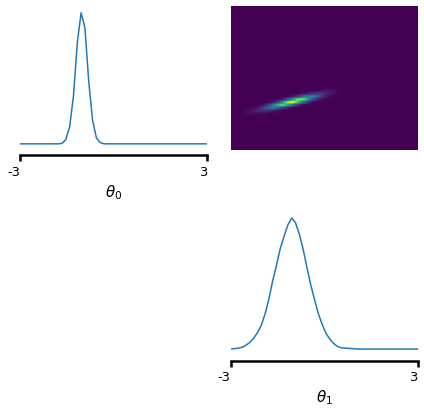

In [10]:
support = torch.vstack([lower_bound,upper_bound]).T
fig, axes = pairplot(samples, limits=support, labels=[r"$\theta_%s$" %i for i in range(num_dims)], ticks=support, **pairplot_kwargs)
beautify_pairplot(axes)
plt.show()

## Inference in Hodgkin-Huxley Models

![sbi](figures/HH_sbi_schematic.png)

## Model and Summary Function

In [11]:
# Stimulation current
I = lambda t: 500.0 if 10.0 <= t and t <= 110.0 else 0.0

# Channel kinetics
a_m = lambda V, VT: -0.32 * (V - VT - 13.0) / (np.exp(-(V - VT - 13.0) / 4.0) - 1.0)
b_m = lambda V, VT: 0.28 * (V - VT - 40.0) / (np.exp((V - VT - 40.0) / 5.0) - 1.0)

a_n = lambda V, VT: -0.032 * (V - VT - 15.0) / (np.exp(-(V - VT - 15.0) / 5.0) - 1.0)
b_n = lambda V, VT: 0.5 * np.exp(-(V - VT - 10.0) / 40.0)

a_h = lambda V, VT: 0.128 * np.exp(-(V - VT - 17.0) / 18.0)
b_h = lambda V, VT: 4.0 / (1.0 + np.exp(-(V - VT - 40.0) / 5.0))

# Would be the solution when dm/dt = 0:
m = lambda V, VT: 1.0 / (1.0 + b_m(V, VT)/a_m(V, VT))
n = lambda V, VT: 1.0 / (1.0 + b_n(V, VT)/a_n(V, VT))
h = lambda V, VT: 1.0 / (1.0 + b_h(V, VT)/a_h(V, VT))
p_inf = lambda V: 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

# IVP y = d/dt[f(t,u,p)]
def f(t: float, u: Tuple, gNa: float, gK: float) -> Tuple:
    """Initial Value Problem of the HH-Model.
    
    Args:
        t: time point.
        u: state.
        gNa: sodium conductance.
        gK: potassium conductance.
        
    Returns:
        du, the time derivative of the state.
    """
    V, m, n, h, p = u
    du = np.empty((5,))

    # static parameters
    gleak = 0.1 # mS/cm2
    gM = 0.07 # mS/cm2
    tau_max = 600 # mS
    VT = -60 # mV
    E_leak = -70.0 # mV
    C = 1.0 # uF/cm2
    E_Na = 53 # mV
    E_K = -107 # mV
    area = 15e-5 # cm2

    I_inj = I(t) * 1e-6 # uA

    tau_p = tau_max / (3.3 * np.exp((V + 35) / 20) + np.exp(-(V + 35) / 20))

    du[1] = dmdt = (a_m(V, VT) * (1 - m) - b_m(V, VT) * m)
    du[2] = dndt = (a_n(V, VT) * (1 - n) - b_n(V, VT) * n)
    du[3] = dhdt = (a_h(V, VT) * (1 - h) - b_h(V, VT) * h)
    du[4] = dpdt = ((p_inf(V) - p) / tau_p)

    INa = gNa * m**3 * h * (V - E_Na) * area
    IK = gK * n**4 * (V - E_K) * area
    IM = gM * p * (V - E_K) * area
    Ileak = gleak * (V - E_leak) * area
    Cm = C*area
    
    du[0] = dVdt = -(Ileak + INa + IK + IM - I_inj) / Cm
    
    return du

In [12]:
def hh_model(p: Tuple[int, int] = (20,15), tspan: Tuple[float, float] = (0.0, 120.0), dt: float = 0.04) -> ndarray:
    """Solves the HH IVP for some parameters using an IVP Solver.
    
    Args:
        p: model parameters.
        tspan: time span.
        dt: step size.
        
    Returns:
        t, Vt: time points and corresponding membrane voltages."""

    VT = -60 # same VT as in f
    V0 = -70.0
    u0 = np.array([V0, m(V0, VT), n(V0, VT), h(V0, VT), p_inf(V0)])
    
    t = np.arange(tspan[0], tspan[1], dt)
    sol = solve_ivp(f, tspan, u0, "Radau", args=(p))

    return sol.t, sol.y[0]

def summarise_Vt(Vt:ndarray) -> ndarray:
    """Reduces voltage trace to vector of summary statistics.

    [mean, std, skew, kurtosis, min, max]

    Args:
        Vt: voltage trace.
    
    Returns:
        array of 6 summary stats.
    """
    mean = Vt.mean()
    moments = moment(Vt, range(2,5))
    minmax = np.array([min(Vt),max(Vt)])
    return np.hstack([mean, moments, minmax])

## Observation

In [13]:
theta_o = torch.tensor([[20,15]])
x_o = simulator(theta_o)

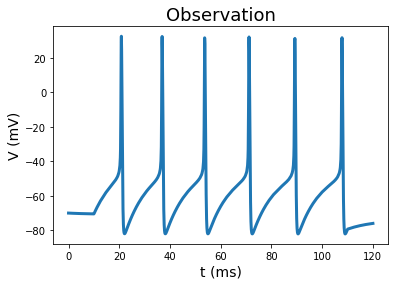

In [14]:
t, Vt = hh_model(theta_o.tolist())

plt.figure(figsize=(6,4))
plt.plot(t, Vt, lw=3)
plt.xlabel("t (ms)", size=14)
plt.ylabel("V (mV)", size=14)
plt.title("Observation", size=18)
plt.show()

## Simulator and Prior

In [15]:
#               gNa       gK
lower_bound = [5.0e-01, 1.0e-04]
upper_bound = [8.0e+01, 3.0e+01]
prior = BoxUniform(low=lower_bound, high=upper_bound)

def simulator(theta: Tensor) -> Tensor:
    """Wrapps HH IVP solver and summarisation and makes it torch compatible.
    
    Args:
        theta: parameter tensor.
        
    Returns:
        x: summary tensor."""
    t, Vt = hh_model(theta.view(-1).tolist())

    x = summarise_Vt(Vt)
    x = torch.from_numpy(x)

    return x

## Inference

In [17]:
posterior = infer(simulator, prior, "SNPE_C", num_simulations=100, num_workers=4)

Running 100 simulations in 100 batches.: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


 Neural network successfully converged after 202 epochs.

In [18]:
samples = posterior.sample((100,), x=x_o)

Drawing 100 posterior samples: 149it [00:00, 11719.23it/s]            


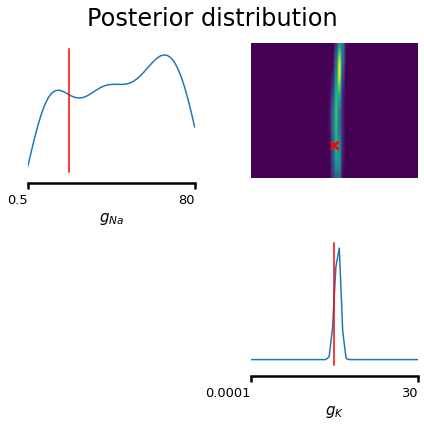

In [19]:
limits = torch.tensor([lower_bound, upper_bound]).T
fig, axes = pairplot(samples, limits=limits, points=theta_o,labels=[r"$g_{Na}$",r"$g_{K}$"], ticks=limits, **pairplot_kwargs)
plt.suptitle("Posterior distribution", size=24)
beautify_pairplot(axes)
plt.show()

Drawing 1 posterior samples: 2445it [00:00, 72552.47it/s]         


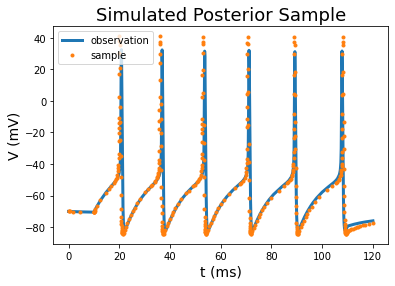

In [20]:
plt.figure(figsize=(6,4))

t, Vt = hh_model(theta_o.view(-1).tolist())
plt.plot(t, Vt, label="observation", lw=3)

sample = posterior.sample((1,), x=x_o)
t, Vt = hh_model(sample.view(-1).tolist())
plt.plot(t, Vt, ".", label="sample", lw=3)
plt.xlabel("t (ms)", size=14)
plt.ylabel("V (mV)", size=14)
plt.title("Simulated Posterior Sample", size=18)
plt.legend()
plt.show()